# Spatial Operator Testing
#### Numerical methods are compared to exact analytical solutions

# Table of Contents <a id="toc"></a>
Convergence Tests:
 * [Tangential Velocity](#tangentialvelocity)
 * Curl
     * [vertex](#curlvertex)
     * [cell center](#curlcellcenter)
 * [Gradient](#gradient)
 * [Divergence](#divergence)

In [2]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [3]:
include(CODE_ROOT * "mode_forward.jl")
include(CODE_ROOT * "mode_init.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [4]:
myMPAS_O = MPAS_Ocean(false, CODE_ROOT * "./MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                    "base_mesh.nc",
                    "mesh.nc")
myMPAS_O.myNamelist

Namelist(1000.0, "uniform", #undef, false, false, true, "Periodic", "Forward_Backward", #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, 0.0, 0.0001, 2.0000000000000002e-11, 10.0, 1000.0, 0.001, "default", "centered", false, 100.0, 1.0e6, 2.2360679774997896e6, 180.0, 0.0, 500.0, 500.0, 1.0, 0.0, 0.5, 12500.0)

## define continuous ocean and analytical form of operators in the form of functions
functions such as surface_elevation_1 calculate and return the value of the surface elevation at x and y

In [5]:
function surface_elevation_1(lX, lY, x, y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lY )
    return eta
end

surface_elevation_1 (generic function with 1 method)

In [6]:
function surface_elevation_gradient_1(lX, lY, x, y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lX )
    
    eta_x = eta0 * (2.0 * pi / lX)*cos( 2.0 * pi * x /lX ) * sin( 2.0 * pi * y/lY)
    eta_y = eta0 * (2.0 * pi / lY)*cos( 2.0 * pi * y /lY ) * sin( 2.0 * pi * x/lX)
    return eta_x, eta_y
end

surface_elevation_gradient_1 (generic function with 1 method)

In [7]:
function surface_elevation_laplacian_1(lX,lY,x,y)
    eta0 = 0.1
    eta = eta0 * sin( 2.0 * pi * x / lX ) * sin( 2.0 * pi * y / lY )
    eta_xx = - ( 2.0 * pi / lX )^2.0 * eta
    eta_yy = - ( 2.0 * pi / lY )^2.0 * eta
    laplacian = eta_xx + eta_yy
    return laplacian
end

surface_elevation_laplacian_1 (generic function with 1 method)

In [8]:
function problem_specific_prefix_1()
    prefix = "Expt1_"
    return prefix
end

problem_specific_prefix_1 (generic function with 1 method)

In [9]:
surface_elevation = surface_elevation_1

surface_elevation_gradient = surface_elevation_gradient_1

surface_elevation_laplacian = surface_elevation_laplacian_1

problem_specific_prefix = problem_specific_prefix_1

problem_specific_prefix_1 (generic function with 1 method)

In [10]:
function velocity(lX,lY,x,y)
    eta_x, eta_y = surface_elevation_gradient(lX,lY,x,y) 
    f = 10.0^(-4.0)
    g = 10.0
    v = gravity*eta_x/f
    u = -gravity*eta_y/f
    return u, v
end

velocity (generic function with 1 method)

In [11]:
function velocity_curl(lX,lY,x,y)
    f = 10.0^(-4.0)
    g = 10.0
    zeta = gravity/f*surface_elevation_laplacian(lX,lY,x,y)
    return zeta
end

velocity_curl (generic function with 1 method)

In [12]:
function ComputeNormalAndTangentialComponentsAtEdge(myVectorQuantityAtEdge,angleEdge,returningComponent)
    nEdges = length(angleEdge)
    if returningComponent == "normal" || returningComponent == "both"
        myVectorQuantityAtEdgeNormalComponent = zeros(nEdges)
    end
    if returningComponent == "tangential" || returningComponent == "both"
        myVectorQuantityAtEdgeTangentialComponent = zeros(nEdges)
    end
    for iEdge in range(0+1,nEdges,step=1)
        xComponent = myVectorQuantityAtEdge[iEdge,0+1]
        yComponent = myVectorQuantityAtEdge[iEdge,1+1]
        if returningComponent == "normal" || returningComponent == "both"
            myVectorQuantityAtEdgeNormalComponent[iEdge] = (xComponent*cos(angleEdge[iEdge]) 
                                                            + yComponent*sin(angleEdge[iEdge]))
        end
        if returningComponent == "tangential" || returningComponent == "both"
            myVectorQuantityAtEdgeTangentialComponent[iEdge] = (yComponent*cos(angleEdge[iEdge]) 
                                                            - xComponent*sin(angleEdge[iEdge]))
        end
    end
    if returningComponent == "normal"
        return myVectorQuantityAtEdgeNormalComponent
    elseif returningComponent == "tangential"
        return myVectorQuantityAtEdgeTangentialComponent
    else # if returningComponent == "both"
        return myVectorQuantityAtEdgeNormalComponent, myVectorQuantityAtEdgeTangentialComponent
    end
end

ComputeNormalAndTangentialComponentsAtEdge (generic function with 1 method)

In [349]:
function convergence_test(periodicity, mesh_directory, operator_name, test)
    nCases = 6
    dc = zeros(Float64, nCases)
    MaxErrorNorm = zeros(Float64, nCases)
    L2ErrorNorm = zeros(Float64, nCases)
    
    for iCase = 1:nCases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$iCase.nc"
        else
            base_mesh_file_name = "culled_mesh_$iCase.nc"
        end
        mesh_file_name = "mesh_$iCase.nc"
        dc[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
                test(false, false, mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    end
    
    A = [log10.(dc)    ones(length(dc))]
    m, c = A \ log10.(MaxErrorNorm)
    y = m*log10.(dc) .+ c
    y = 10 .^ y
    
    fig, ax = subplots(1,1)
    loglog(dc, MaxErrorNorm, label="Maximum Error Norm", marker="s")
    loglog(dc, y, label="Best Fit Line, slope=$m")
    ax.set_title("Convergence Plot of Maximum Error Norm of $operator_name")
    ax.legend()
    ax.set_xlabel("Grid cell size")
    ax.set_ylabel("Maximum Error Norm of $operator_name")
    grid(which="both")
    
    
    A = [log10.(dc)    ones(length(dc))]
    m, c = A \ log10.(L2ErrorNorm)
    y = m*log10.(dc) .+ c
    y = 10 .^ y
    
    fig, ax = subplots(1,1)
    loglog(dc, L2ErrorNorm, label="L2 Error Norm", marker="s")
    loglog(dc, y, label="Best Fit Line, slope=$m")
    ax.set_title("Convergence Plot of L2 Error Norm of $operator_name")
    ax.legend()
    ax.set_xlabel("Grid cell size")
    ax.set_ylabel("L2 Error Norm of $operator_name")
    grid(which="both")
end

convergence_test (generic function with 1 method)

# Tangential Velocity Test

## define numerical method for tangential velocity

In [348]:
function numerical_tangential_velocity(myMPAS_O,myNormalVelocity,periodicity)
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        ocn_init_routines_compute_max_level!(myMPAS_O)
    end
    
    myTangentialVelocity = zeros(myMPAS_O.nEdges)
    for iEdge in range(0+1,myMPAS_O.nEdges,step=1)
        if ((periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy") 
            && myMPAS_O.boundaryEdge[iEdge] == 1.0)
            u, v = velocity(myMPAS_O.lX,myMPAS_O.lY,myMPAS_O.xEdge[iEdge],myMPAS_O.yEdge[iEdge])
            myTangentialVelocity[iEdge] = v*cos(myMPAS_O.angleEdge[iEdge]) - u*sin(myMPAS_O.angleEdge[iEdge])
        else
            myTangentialVelocity[iEdge] = 0.0
            # Compute tangential velocities
            for i in range(0+1,myMPAS_O.nEdgesOnEdge[iEdge],step=1)
                eoe = myMPAS_O.edgesOnEdge[i,iEdge]
                weightOnEdge = myMPAS_O.weightsOnEdge[i,iEdge]
                myTangentialVelocity[iEdge] += weightOnEdge*myNormalVelocity[eoe]
            end
        end
    end
    return myTangentialVelocity
end

numerical_tangential_velocity (generic function with 2 methods)

## compare numerical and analytical tangential velocity

In [350]:
function test_tangential_velocity(useDefaultMesh,plotFigures,mesh_directory,base_mesh_file_name,mesh_file_name,periodicity)
    if useDefaultMesh
        myMPAS_O = MPAS_Ocean(false,periodicity=periodicity)
    else
        myMPAS_O = MPAS_Ocean(false,mesh_directory,base_mesh_file_name,mesh_file_name,
                                           periodicity=periodicity)
    end
        
    if periodicity == "NonPeriodic_x"
        iEdgeStartingIndex = 1+1
    else
        iEdgeStartingIndex = 0+1
    end
    
    prefix = problem_specific_prefix()
    myAnalyticalVelocityComponentsAtEdge = zeros((myMPAS_O.nEdges,2))
    myAnalyticalNormalVelocity = zeros(myMPAS_O.nEdges)
    myAnalyticalTangentialVelocity = zeros(myMPAS_O.nEdges)
    
    for iEdge in range(0+1,myMPAS_O.nEdges,step=1)
        myAnalyticalVelocityComponentsAtEdge[iEdge,0+1], myAnalyticalVelocityComponentsAtEdge[iEdge,1+1] = (
            velocity(myMPAS_O.lX,myMPAS_O.lY,myMPAS_O.xEdge[iEdge],myMPAS_O.yEdge[iEdge])
        )
    end
    
    myAnalyticalNormalVelocity, myAnalyticalTangentialVelocity = (
    ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocityComponentsAtEdge,myMPAS_O.angleEdge,"both"))
    myNumericalTangentialVelocity = (
    numerical_tangential_velocity(myMPAS_O,myAnalyticalNormalVelocity,periodicity))
    myTangentialVelocityError = myNumericalTangentialVelocity - myAnalyticalTangentialVelocity
    MaxErrorNorm = norm(myTangentialVelocityError,Inf)
    L2ErrorNorm = (norm(myTangentialVelocityError)
                   /sqrt(float(myMPAS_O.nEdges - myMPAS_O.nNonPeriodicBoundaryEdges)))
    @sprintf("The maximum error norm of the tangential velocity is %.3g.", MaxErrorNorm)
    @sprintf("The L2 error norm of the tangential velocity is %.3g.", L2ErrorNorm)  
    
    if plotFigures
        xLabel = "Zonal Distance (km)"
        yLabel = "Meridional Distance (km)"
        
        
        Title = "Analytical Tangential Velocity"
        FigureTitle = prefix * "TangentialVelocity_Analytical"
        fig, ax, _, _ = edgeHeatMapMesh(myMPAS_O, myAnalyticalTangentialVelocity)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
        
        Title = "Numerical Tangential Velocity"
        FigureTitle = prefix * "TangentialVelocity_Numerical"
        fig, ax, _, _  = edgeHeatMapMesh(myMPAS_O, myNumericalTangentialVelocity)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
        
        Title = "Tangential Velocity Error"
        FigureTitle = prefix * "TangentialVelocity_Error"
        fig, ax, _, _ = edgeHeatMapMesh(myMPAS_O, myTangentialVelocityError)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_title(Title)
        fig.suptitle(FigureTitle)
        display(fig)
    end
    
    return myMPAS_O.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

test_tangential_velocity (generic function with 1 method)

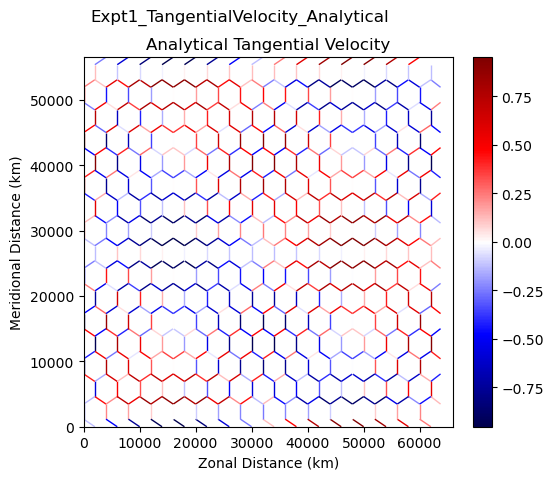

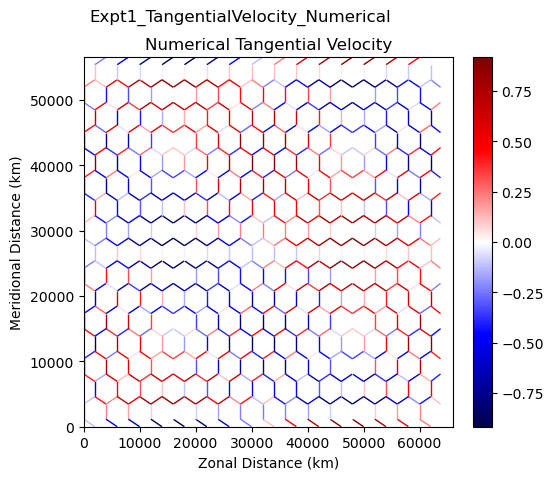

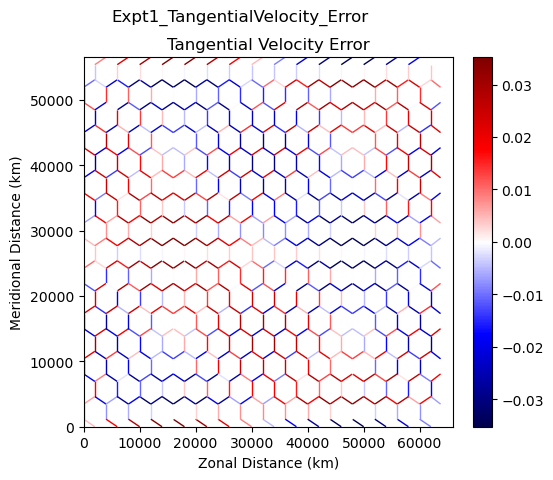

(4000.0000000000014, 0.03522852369604257, 0.019366965729409987)

In [351]:
test_tangential_velocity(false, true,
                    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                        "base_mesh_3.nc", "mesh_3.nc", "Periodic")

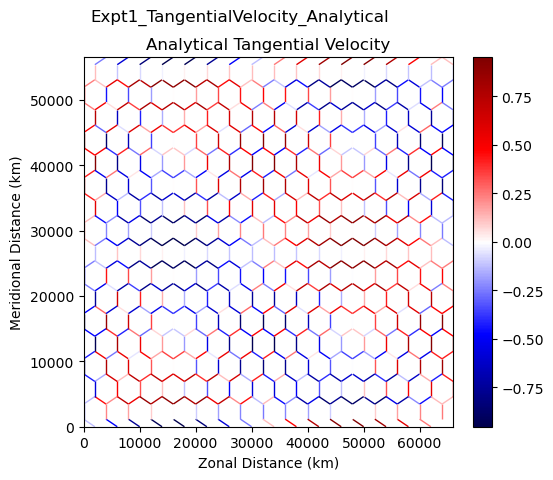

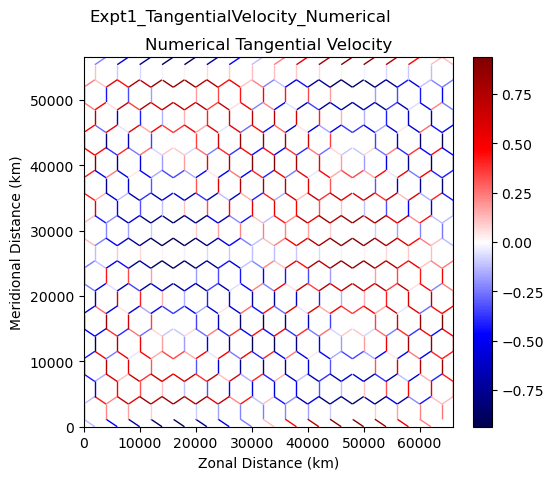

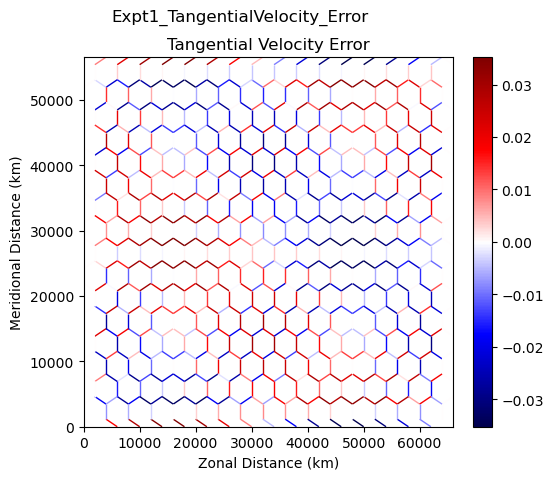

(4000.0000000000014, 0.03522852369604257, 0.01937961082547361)

In [352]:
test_tangential_velocity(false, true,
        CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/$periodicity",
        "culled_mesh_3.nc", "mesh_3.nc", periodicity)

## run convergence test to see how error scales with cell width

In [267]:
function convergence_test_tangential_velocity(periodicity,mesh_directory)
    nCases = 6
    dc = zeros(nCases)
    MaxErrorNorm = zeros(nCases)
    L2ErrorNorm = zeros(nCases)
    prefix = problem_specific_prefix()
    
    for iCase in range(0+1,nCases,step=1)
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$(iCase+1).nc"
        elseif periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
            base_mesh_file_name = "culled_mesh_$(iCase+1).nc"
        end
        mesh_file_name = "mesh_$(iCase+1).nc"
        dc[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] = (
        test_tangential_velocity(false,false,mesh_directory,base_mesh_file_name,mesh_file_name,periodicity))
    end
    
    A = [log10.(dc)        ones(length(dc))]
    m, c = ( A \ log10.(MaxErrorNorm) )#[0+1]
    y = m*(log10.(dc)) .+ c
    y = 10.0 .^ y
    
    xLabel = "Cell Width"
    yLabel = "Maximum Error Norm of Numerical Tangential Velocity"
    legends = ["Maximum Error Norm","Best Fit Straight Line"]
    Title = "Convergence Plot w.r.t. Maximum Error Norm: Slope is $m"
    FigureTitle = prefix * "ConvergencePlot_NumericalTangentialVelocity_MaxErrorNorm" 
    # * is string concatenation in julia
    
    
    fig, ax = subplots(1,1)
    loglog(dc, MaxErrorNorm, label=legends[1], marker="s")
    loglog(dc, y, label=legends[2])
    xlabel(xLabel)
    ylabel(yLabel)
    ax.set_title(Title)
    ax.legend()
    grid(which="both")
   
    m, c = ( A \ log10.(L2ErrorNorm) )
    y = m*(log10.(dc)) .+ c
    y = 10.0 .^ y
    xLabel = "Cell Width"
    yLabel = "L2 Error Norm of Numerical Tangential Velocity"
    legends = ["L2 Error Norm","Best Fit Straight Line"]
    Title = "Convergence Plot w.r.t. L2 Error Norm: Slope is $m"
    FigureTitle = prefix * "ConvergencePlot_NumericalTangentialVelocity_L2ErrorNorm" 
    # * is string concatenation in julia
    
    fig, ax = subplots(1,1)
    loglog(dc, L2ErrorNorm, label=legends[1], marker="s")
    loglog(dc, y, label=legends[2])
    xlabel(xLabel)
    ylabel(yLabel)
    ax.set_title(Title)
    ax.legend()
    grid(which="both")
    
end

convergence_test_tangential_velocity (generic function with 1 method)

<a id="tangentialvelocity"></a>
[Back to Top](#toc)

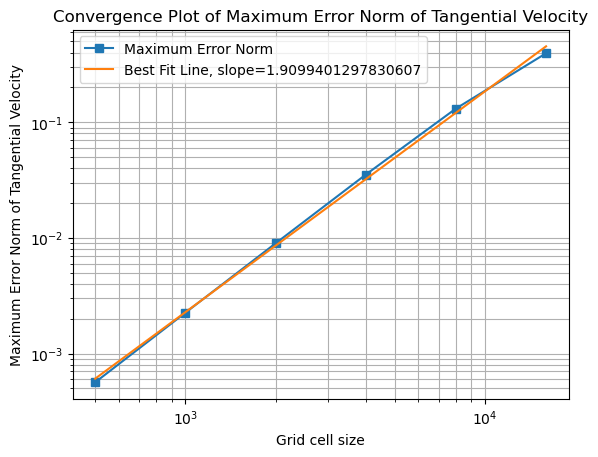

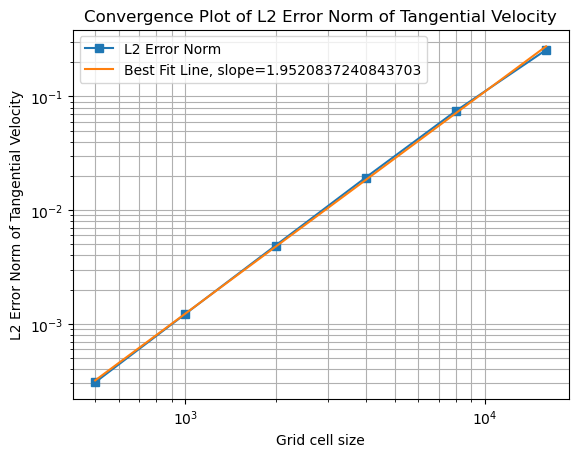

In [353]:
convergence_test("Periodic",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
            "Tangential Velocity",
            test_tangential_velocity)

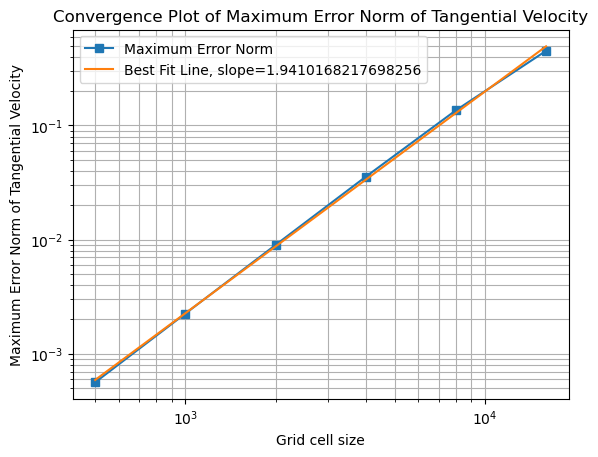

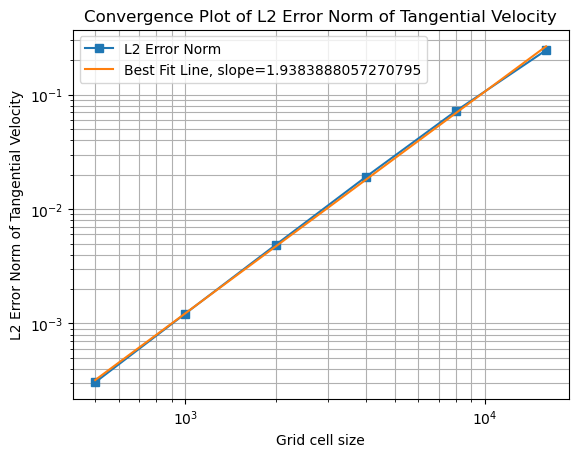

In [354]:
convergence_test("NonPeriodic_xy",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/NonPeriodic_xy",
            "Tangential Velocity",
            test_tangential_velocity)

## success
plots have a slope ~2, meaning the error scales with the cell width like it should!

In [301]:
function numerical_curl_operator_at_vertex(myMPAS_O, myNormalVelocity, periodicity)
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        ocn_init_routines_compute_max_level!(myMPAS_O)
    end
    
    myCurlAtVertex = zeros(Float64, myMPAS_O.nVertices)
    for iVertex = 1:myMPAS_O.nVertices
        if (periodicity !== "Periodic" && myMPAS_O.boundaryVertex[iVertex] == 1.0)
            myCurlAtVertex[iVertex] = velocity_curl(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xVertex[iVertex], myMPAS_O.yVertex[iVertex])
        else
            for i = 1:myMPAS_O.vertexDegree
                iEdge = myMPAS_O.edgesOnVertex[i, iVertex]
                if iEdge == 0
                    println(myMPAS_O.boundaryVertex[iVertex])
                end
                myCurlAtVertex[iVertex] += myMPAS_O.dcEdge[iEdge] * myNormalVelocity[iEdge] * myMPAS_O.edgeSignOnVertex[iVertex,i]
            end
            myCurlAtVertex[iVertex] /= myMPAS_O.areaTriangle[iVertex]
        end
    end
    return myCurlAtVertex
end

numerical_curl_operator_at_vertex (generic function with 2 methods)

In [302]:
function test_curl_at_vertex(useDefaultMesh, plotFigures,
                        mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    
    if useDefaultMesh
        myMPAS_O = MPAS_Ocean(false,periodicity=periodicity)
    else
        myMPAS_O = MPAS_Ocean(false,mesh_directory,base_mesh_file_name,mesh_file_name,
                                           periodicity=periodicity)
    end
    
    myAnalyticalVelocity = zeros(Float64, (myMPAS_O.nEdges, 2))
    for iEdge = 1:myMPAS_O.nEdges
        myAnalyticalVelocity[iEdge,1], myAnalyticalVelocity[iEdge,2] = velocity(myMPAS_O.lX, myMPAS_O.lY,
                                                                                    myMPAS_O.xEdge[iEdge], myMPAS_O.yEdge[iEdge])
    end
    
    myAnalyticalNormalVelocity = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocity, myMPAS_O.angleEdge, "normal")
    
    
    myNumericalCurl = numerical_curl_operator_at_vertex(myMPAS_O, myAnalyticalNormalVelocity, periodicity)
    
    
    myAnalyticalCurl = zeros(Float64, myMPAS_O.nVertices)
    for iVertex = 1:myMPAS_O.nVertices
        myAnalyticalCurl[iVertex] = velocity_curl(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xVertex[iVertex], myMPAS_O.yVertex[iVertex])
    end
    
    
    myCurlError = myNumericalCurl - myAnalyticalCurl
    MaxErrorNorm = norm(myCurlError, Inf)
    L2ErrorNorm = norm(myCurlError) / sqrt(float(myMPAS_O.nVertices - myMPAS_O.nNonPeriodicBoundaryVertices))
    
    if plotFigures
        fig, ax, _, _ = vertexHeatMapMesh(myMPAS_O, myAnalyticalCurl, dotsize=10)
        ax.set_title("Analytical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = vertexHeatMapMesh(myMPAS_O, myNumericalCurl, dotsize=10)
        ax.set_title("Numerical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = vertexHeatMapMesh(myMPAS_O, myCurlError, dotsize=10)
        ax.set_title("Curl Error")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
    end
    
    return myMPAS_O.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

test_curl_at_vertex (generic function with 3 methods)

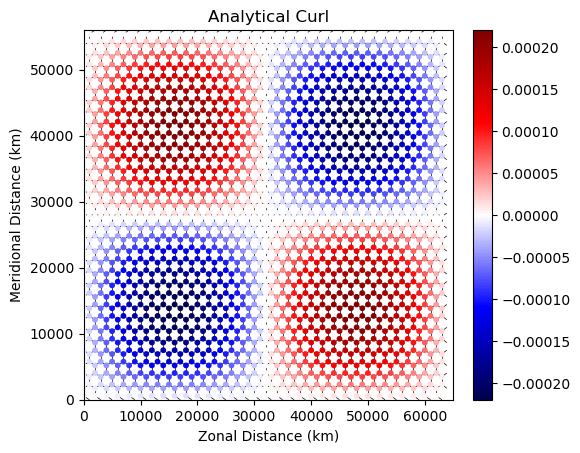

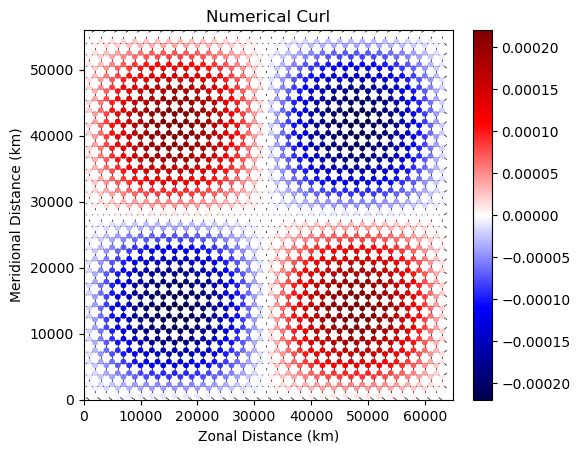

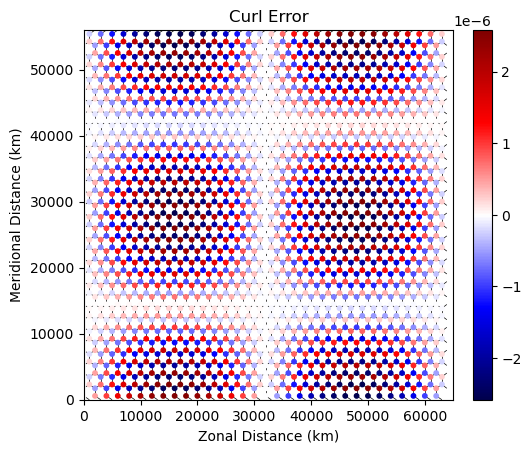

(1999.9999999999989, 2.581847408144001e-6, 1.2910611796538649e-6)

In [303]:
test_curl_at_vertex(false, true, CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                "base_mesh_4.nc", "mesh_4.nc", "Periodic")

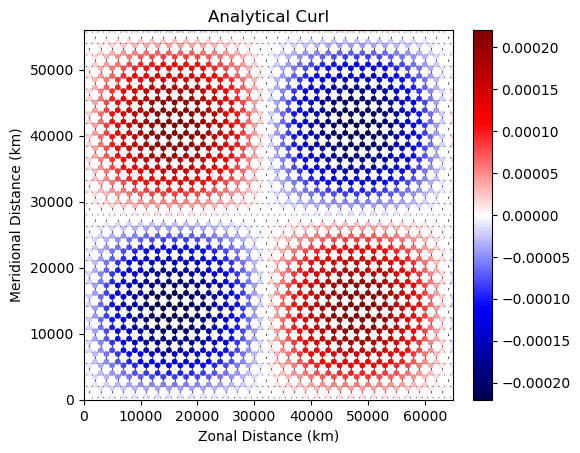

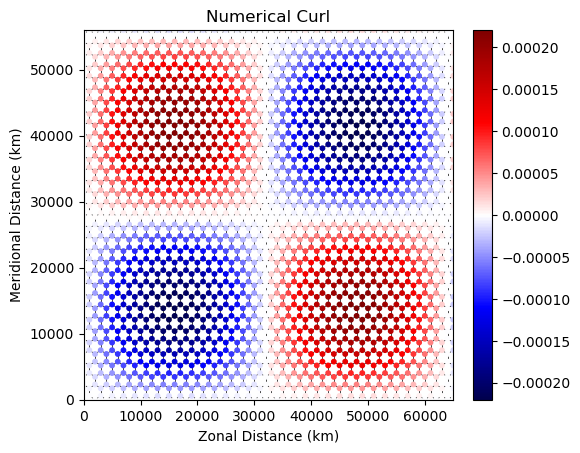

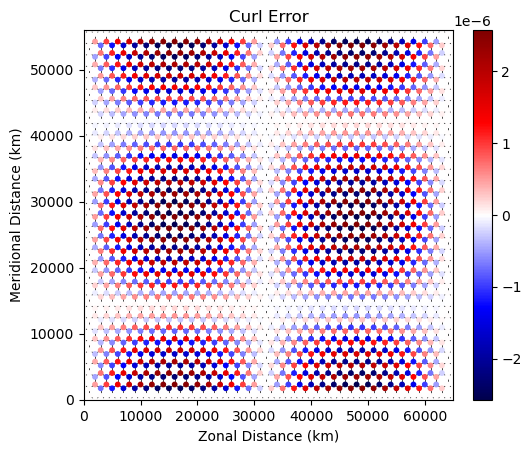

(1999.9999999999998, 2.5738550351854334e-6, 1.2903376427183556e-6)

In [304]:
test_curl_at_vertex(false, true, CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/NonPeriodic_xy",
                "culled_mesh_4.nc", "mesh_4.nc", "NonPeriodic_xy")

## now do test of curl at cell centers instead of vertices

In [307]:
function numerical_curl_operator_at_cell_center(myMPAS_O, myNormalVelocity, periodicity)
    myCurlAtVertex = numerical_curl_operator_at_vertex(myMPAS_O, myNormalVelocity, periodicity)
    myCurlAtCellCenter = zeros(Float64, myMPAS_O.nCells)
    for iCell = 1:myMPAS_O.nCells
        for i = 1:myMPAS_O.nEdgesOnCell[iCell]
            iVertex = myMPAS_O.verticesOnCell[i, iCell]
            iKite = myMPAS_O.kiteIndexOnCell[iCell, i] #- 1
            myCurlAtCellCenter[iCell] += myMPAS_O.kiteAreasOnVertex[iKite, iVertex] * myCurlAtVertex[iVertex]
        end
        myCurlAtCellCenter[iCell] /= myMPAS_O.areaCell[iCell]
    end
    return myCurlAtCellCenter
end

numerical_curl_operator_at_cell_center (generic function with 1 method)

In [308]:
function test_curl_at_cell_center(useDefaultMesh, plotFigures,
                            mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    
    if useDefaultMesh
        myMPAS_O = MPAS_Ocean(false,periodicity=periodicity)
    else
        myMPAS_O = MPAS_Ocean(false,mesh_directory,base_mesh_file_name,mesh_file_name,
                                           periodicity=periodicity)
    end
    
    myAnalyticalVelocity = zeros(Float64, (myMPAS_O.nEdges, 2))
    for iEdge = 1:myMPAS_O.nEdges
        myAnalyticalVelocity[iEdge,1], myAnalyticalVelocity[iEdge,2] = velocity(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xEdge[iEdge], myMPAS_O.yEdge[iEdge])
    end
    
    myAnalyticalNormalVelocity = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocity, myMPAS_O.angleEdge, "normal")
    
    
    myNumericalCurl = numerical_curl_operator_at_cell_center(myMPAS_O, myAnalyticalNormalVelocity, periodicity)
    
    
    myAnalyticalCurl = zeros(Float64, myMPAS_O.nCells)
    for iCell = 1:myMPAS_O.nCells
        myAnalyticalCurl[iCell] = velocity_curl(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xCell[iCell], myMPAS_O.yCell[iCell])
    end
    
    
    myCurlError = myNumericalCurl - myAnalyticalCurl
    MaxErrorNorm = norm(myCurlError, Inf)
    L2ErrorNorm = norm(myCurlError) / sqrt(float(myMPAS_O.nVertices - myMPAS_O.nNonPeriodicBoundaryVertices))
    
    if plotFigures
        fig, ax, _, _ = heatMapMesh(myMPAS_O, myAnalyticalCurl)
        ax.set_title("Analytical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(myMPAS_O, myNumericalCurl)
        ax.set_title("Numerical Curl")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(myMPAS_O, myCurlError)
        ax.set_title("Curl Error")
        ax.set_xlabel("Zonal Distance (km)")
        ax.set_ylabel("Meridional Distance (km)")
        display(fig)
    end
    
    return myMPAS_O.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

test_curl_at_cell_center (generic function with 1 method)

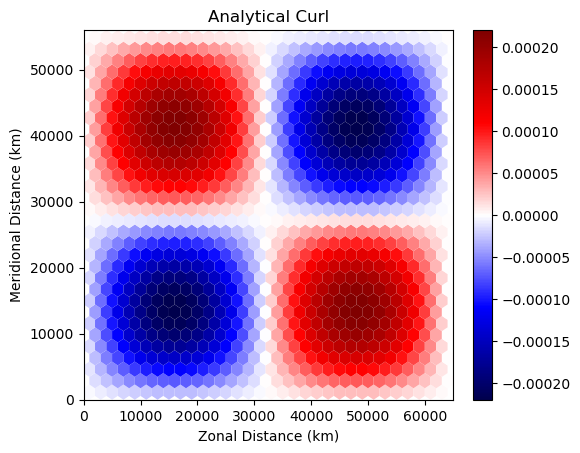

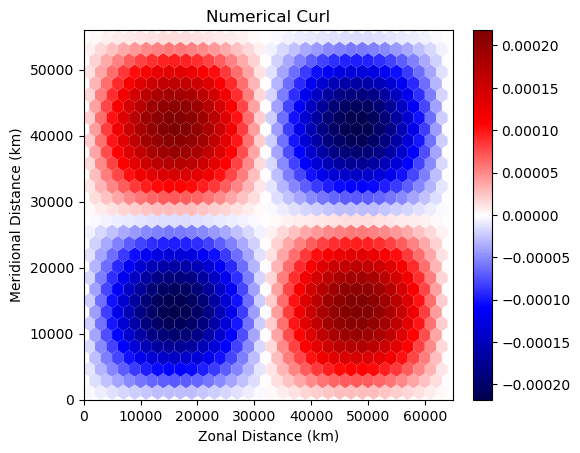

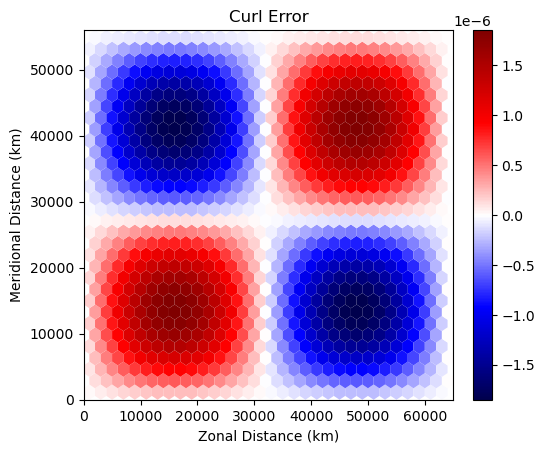

(1999.9999999999989, 1.8497355306069908e-6, 6.553834949174761e-7)

In [309]:
test_curl_at_cell_center(false, true, CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                    "base_mesh_4.nc", "mesh_4.nc", "Periodic")

<a id="curlvertex"></a>
[Back to Top](#toc)

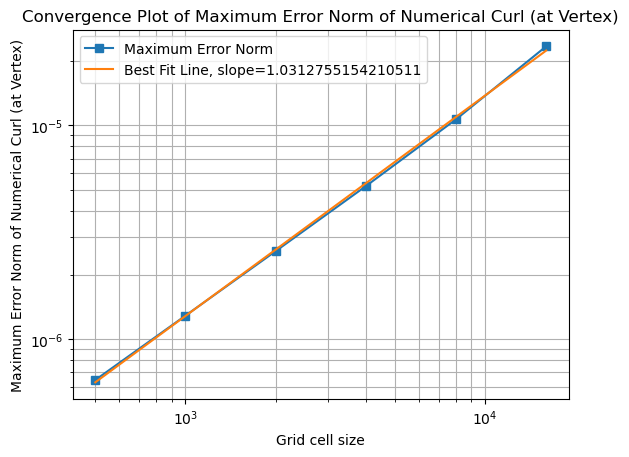

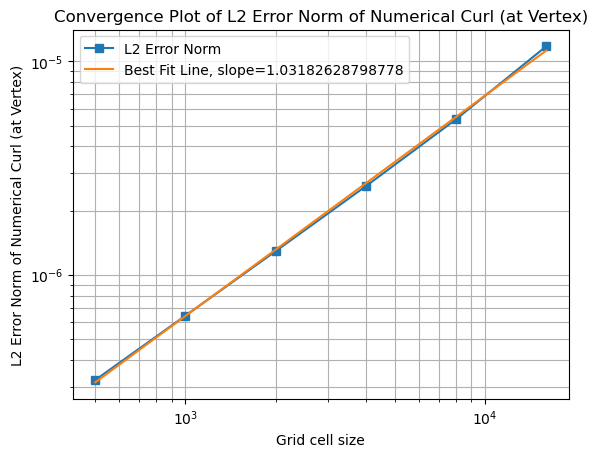

In [311]:
convergence_test("Periodic",
                    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                    "Numerical Curl (at Vertex)",
                    test_curl_at_vertex)

## interesting detail:
the curl error at the vertex scales linearly, with a slope of 1 on the log plot.
but the curl error calculated at the cell centers scales quadratically, with a slope of 2 on the log plot.

<a id="curlcellcenter"></a>
[Back to Top](#toc)

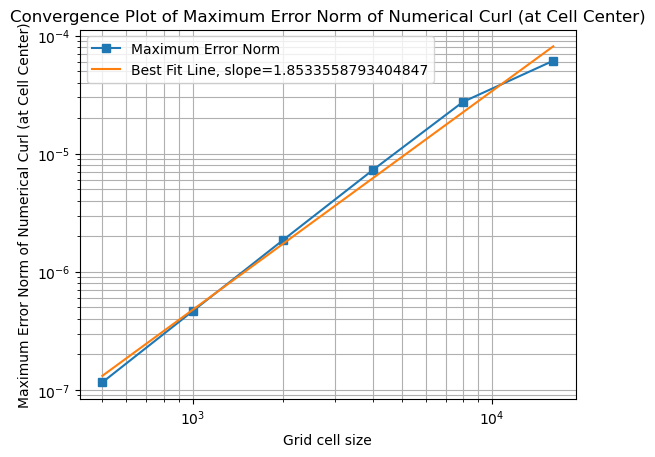

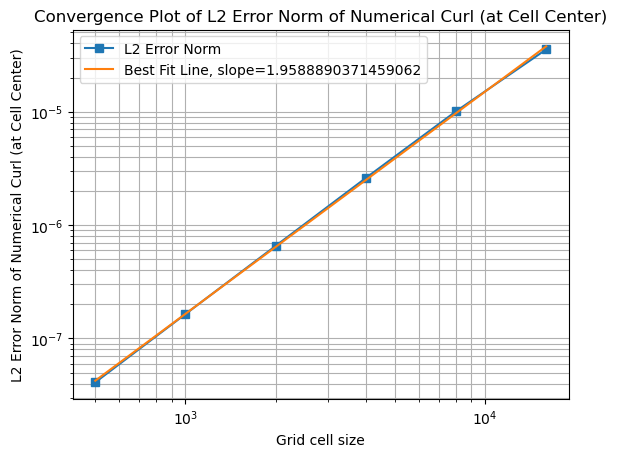

In [312]:
convergence_test("Periodic",
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                "Numerical Curl (at Cell Center)",
                test_curl_at_cell_center)

# gradient operator test

In [313]:
function numerical_gradient_operator(myMPAS_O, myScalarAtCellCenters, periodicity)
    if periodicity == "NonPeriodic_x" || periodicity == "NonPeriodic_y" || periodicity == "NonPeriodic_xy"
        ocn_init_routines_compute_max_level!(myMPAS_O)
    end
    
    myNumericalGradientNormalToEdge = zeros(Float64, myMPAS_O.nEdges)
    for iEdge = 1:myMPAS_O.nEdges
        if ! (periodicity !== "Periodic" && myMPAS_O.boundaryEdge[iEdge])
            cell1, cell2 = myMPAS_O.cellsOnEdge[:,iEdge]
            myNumericalGradientNormalToEdge[iEdge] = ( myScalarAtCellCenters[cell2] - myScalarAtCellCenters[cell1] ) / myMPAS_O.dcEdge[iEdge]
        end
    end
    
    return myNumericalGradientNormalToEdge
end

numerical_gradient_operator (generic function with 1 method)

In [317]:
function test_numerical_gradient_operator(useDefaultMesh, plotFigures,
                                mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    
    if useDefaultMesh
        myMPAS_O = MPAS_Ocean(false, periodicity=periodicity)
    else
        myMPAS_O = MPAS_Ocean(false, mesh_directory, base_mesh_file_name, mesh_file_name, periodicity=periodicity)
    end
    
    
    myAnalyticalGradientAtEdge = zeros(Float64, myMPAS_O.nEdges, 2)
    for iEdge = 1:myMPAS_O.nEdges
        myAnalyticalGradientAtEdge[iEdge,1], myAnalyticalGradientAtEdge[iEdge,2] =
                    surface_elevation_gradient(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xEdge[iEdge], myMPAS_O.yEdge[iEdge])
    end
    myAnalyticalGradientNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalGradientAtEdge, myMPAS_O.angleEdge, "normal")
    
    ssh = zeros(Float64, myMPAS_O.nCells)
    for iCell = 1:myMPAS_O.nCells
        ssh[iCell] = surface_elevation(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xCell[iCell], myMPAS_O.yCell[iCell])
    end
    myNumericalGradientNormalToEdge = numerical_gradient_operator(myMPAS_O, ssh, periodicity)
    
    myGradientError = myNumericalGradientNormalToEdge - myAnalyticalGradientNormalToEdge
    
    MaxErrorNorm = norm(myGradientError, Inf)
    L2ErrorNorm = norm(myGradientError) / sqrt(myMPAS_O.nEdges - myMPAS_O.nNonPeriodicBoundaryEdges)
    
    @sprintf("Maximum Error Norm of the gradient is %.3g.", MaxErrorNorm)
    @sprintf("L2 Error norm of the gradient is %.3g.", L2ErrorNorm)
    
    if plotFigures
        ylabel = "Meridional Distance (km)"
        xlabel = "Zonal Distance (km)"
        
        fig, ax, cbar, _ = edgeHeatMapMesh(myMPAS_O, myAnalyticalGradientNormalToEdge)
        ax.set_title("Analytical Gradient on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(myMPAS_O, myAnalyticalGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
#         ssh = [surface_elevation(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xCell[iCell], myMPAS_O.yCell[iCell]) for iCell = 1:myMPAS_O.nCells]
#         fig, ax, _, _ = heatMapMesh(myMPAS_O, ssh)
#         ax.set_title("ssh")
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel(ylabel)
#         display(fig)
        
        fig, ax, cbar, _ = edgeHeatMapMesh(myMPAS_O, myNumericalGradientNormalToEdge)
        ax.set_title("Numerical Gradient on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(myMPAS_O, myNumericalGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        fig, ax, cbar, _ = edgeHeatMapMesh(myMPAS_O, myGradientError)
        ax.set_title("Gradient Error on Edges")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(myMPAS_O, myGradientError, fig=fig, ax=ax, cbar=cbar)
        display(fig)
    end
    
    return myMPAS_O.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

test_numerical_gradient_operator (generic function with 1 method)

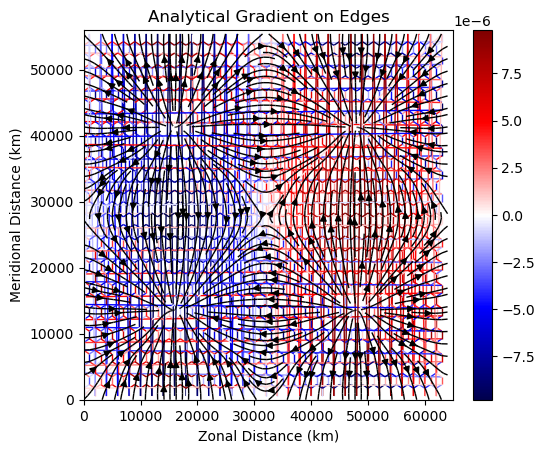

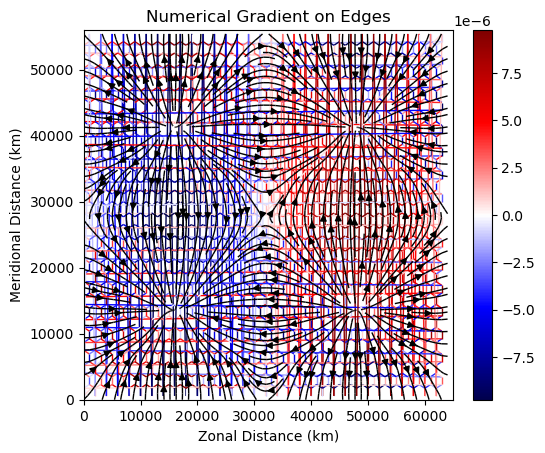

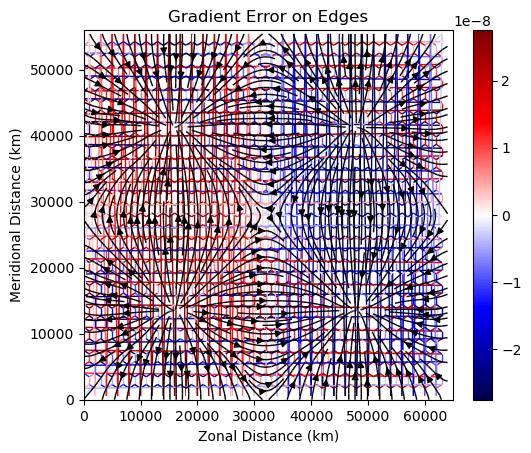

(1999.9999999999989, 2.751880037923842e-8, 1.6018755798627788e-8)

In [318]:
test_numerical_gradient_operator(false, true,
        CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
        "base_mesh_4.nc", "mesh_4.nc", "Periodic")

<a id="gradient"></a>
[Back to Top](#toc)

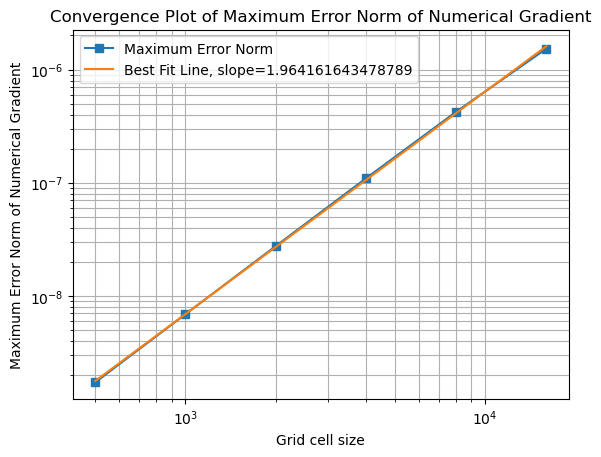

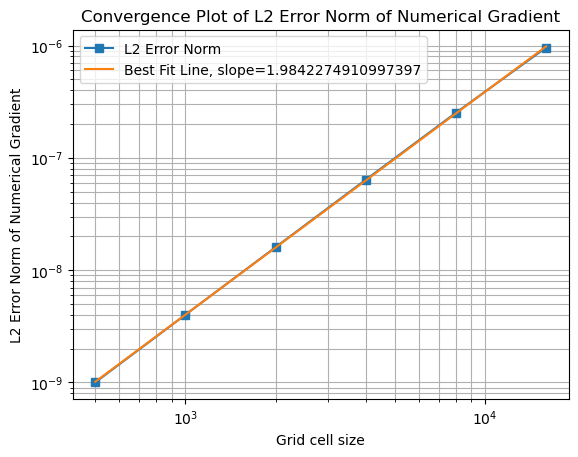

In [319]:
convergence_test("Periodic",
                    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                    "Numerical Gradient",
                    test_numerical_gradient_operator)

# Divergence operator test

In [320]:
function numerical_divergence_operator(myMPAS_O, myVectorLengthNormalToEdge, periodicity)
    myDivergenceOfCell = zeros(Float64, myMPAS_O.nCells)
    for iCell = 1:myMPAS_O.nCells
        for i = 1:myMPAS_O.nEdgesOnCell[iCell]
            iEdge = myMPAS_O.edgesOnCell[i, iCell]
            if !(periodicity !== "Periodic" && myMPAS_O.boundaryEdge[iEdge])
                myDivergenceOfCell[iCell] -= myMPAS_O.dvEdge[iEdge] * myVectorLengthNormalToEdge[iEdge] * myMPAS_O.edgeSignOnCell[iCell, i]
            end
        end
        myDivergenceOfCell[iCell] /= myMPAS_O.areaCell[iCell]
    end
    return myDivergenceOfCell
end

numerical_divergence_operator (generic function with 1 method)

In [321]:
function test_numerical_divergence_operator(useDefaultMesh, plotFigures,
                                    mesh_directory, base_mesh_file_name, mesh_file_name, periodicity)
    if useDefaultMesh
        myMPAS_O = MPAS_Ocean(false, periodicity=periodicity)
    else
        myMPAS_O = MPAS_Ocean(false, mesh_directory, base_mesh_file_name, mesh_file_name, periodicity=periodicity)
    end
    
    myAnalyticalSSHGradient = zeros(Float64, myMPAS_O.nEdges, 2)
    for iEdge = 1:myMPAS_O.nEdges
        myAnalyticalSSHGradient[iEdge,1], myAnalyticalSSHGradient[iEdge,2] =
                            surface_elevation_gradient(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xEdge[iEdge], myMPAS_O.yEdge[iEdge])
    end
    myAnalyticalSSHGradientNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalSSHGradient, myMPAS_O.angleEdge, "normal")
    
    
    myNumericalSSHLaplacian = numerical_divergence_operator(myMPAS_O, myAnalyticalSSHGradientNormalToEdge, periodicity)
    
    myAnalyticalSSHLaplacian = zeros(Float64, myMPAS_O.nCells)
    for iCell = 1:myMPAS_O.nCells
        myAnalyticalSSHLaplacian[iCell] = surface_elevation_laplacian(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xCell[iCell], myMPAS_O.yCell[iCell])
    end
    
    mySSHLaplacianError = myNumericalSSHLaplacian - myAnalyticalSSHLaplacian
    
    MaxErrorNorm = norm(mySSHLaplacianError, Inf)
    L2ErrorNorm = norm(mySSHLaplacianError) / sqrt(myMPAS_O.nCells)
    
    if plotFigures
        xlabel = "Zonal Distance (km)"
        ylabel = "Meridional Distance (km)"
        
        fig, ax, cbar, _ = heatMapMesh(myMPAS_O, myAnalyticalSSHLaplacian)
        ax.set_title("Analytical Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(myMPAS_O, myAnalyticalSSHGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        
        fig, ax, cbar, _ = heatMapMesh(myMPAS_O, myNumericalSSHLaplacian)
        ax.set_title("Numerical Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        vectorStreamPlotMesh(myMPAS_O, myAnalyticalSSHGradientNormalToEdge, fig=fig, ax=ax, cbar=cbar)
        display(fig)
        
        fig, ax, _, _ = heatMapMesh(myMPAS_O, mySSHLaplacianError)
        ax.set_title("Numerical Error on Laplacian of Surface Elevation")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        display(fig)
    end
    
    return myMPAS_O.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

test_numerical_divergence_operator (generic function with 1 method)

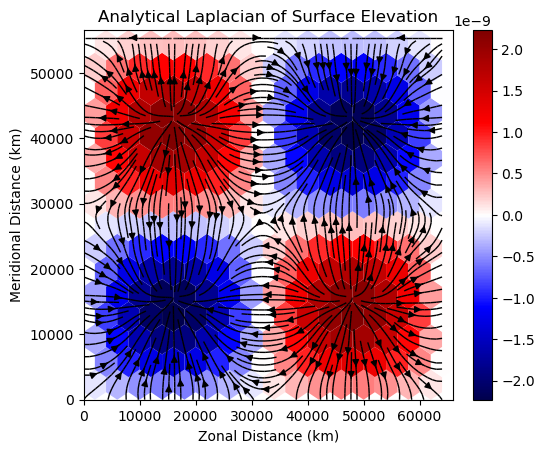

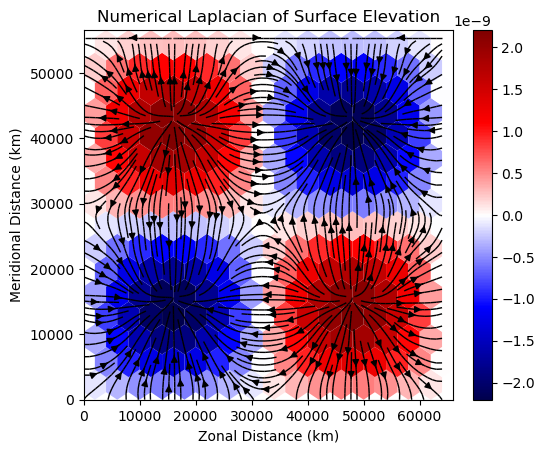

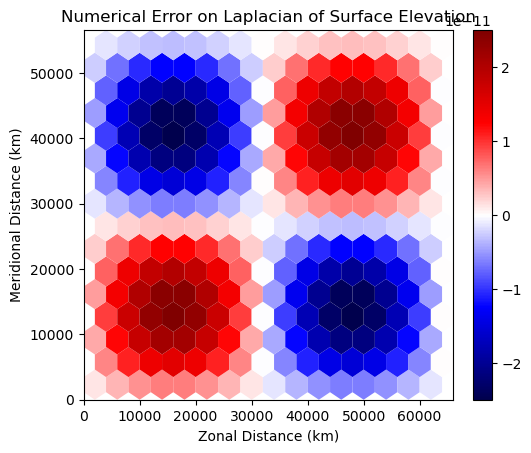

(4000.0000000000014, 2.4974456859681785e-11, 1.2594980231715618e-11)

In [322]:
test_numerical_divergence_operator(false, true,
                    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
                    "base_mesh_3.nc", "mesh_3.nc", "Periodic")

<a id="divergence"></a>
[Back to Top](#toc)

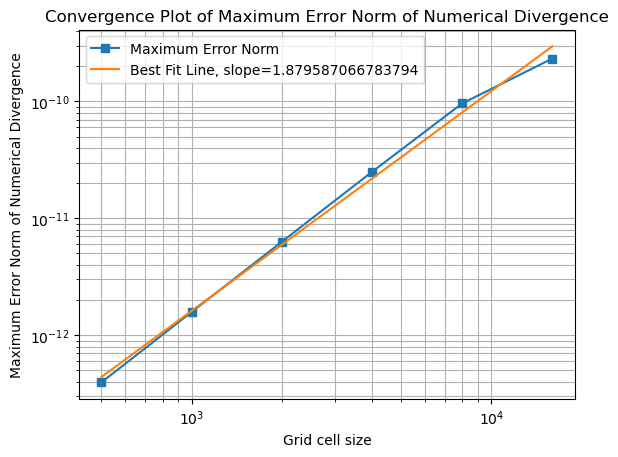

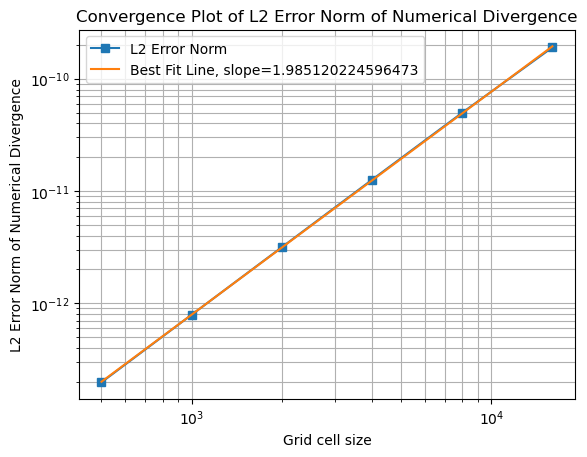

In [323]:
convergence_test("Periodic",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/Periodic",
            "Numerical Divergence",
            test_numerical_divergence_operator)

## testing

In [333]:
myMPAS_O = MPAS_Ocean(false, CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/NonPeriodic_x",
                    "culled_mesh_2.nc", "mesh_2.nc", periodicity="NonPeriodic_x")
typeof(myMPAS_O)

MPAS_Ocean

In [342]:
include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

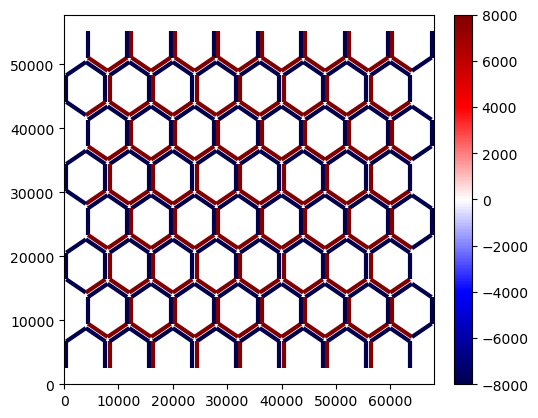

In [347]:
fig, ax, _, _ = signedEdgeHeatMapMesh(myMPAS_O, myMPAS_O.dcEdge, nudge=0.1, linewidth=3)
display(fig)

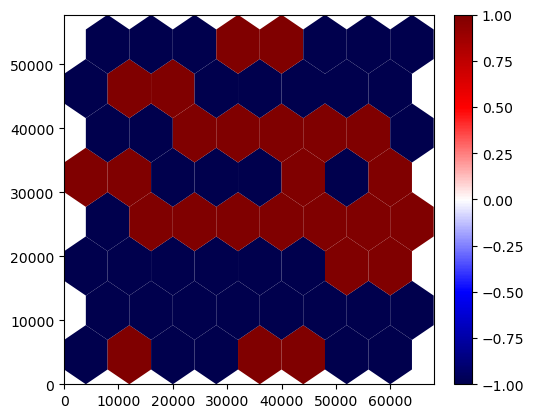

In [343]:
fig, ax, _, _ = heatMapMesh(myMPAS_O, myMPAS_O.edgeSignOnCell[:,1])
display(fig)

In [179]:
myMPAS_O.lX, myMPAS_O.lY

(64000.0, 55425.62584220407)

In [180]:
maximum(myMPAS_O.xCell), maximum(myMPAS_O.yCell)

(64000.0, 54848.27557301445)

## load mesh from a file

In [21]:
minimum(myMPAS_O.edgesOnEdge)

0

In [22]:
maximum(myMPAS_O.edgesOnEdge)

7500

In [23]:
myMPAS_O.nEdges

7500

## define dt, duration of the simulation, number of snapshots of the sea surface height to record, and arrays for recording it

In [3]:
# calculate dt based on CFL condition
dt = 0.1 * minimum(myMPAS_O.dcEdge) / sqrt( gravity  * maximum(myMPAS_O.bottomDepth) )

nFrames = 100

simTimeBetweenFrames = 3*dt

"dt: ", dt

("dt: ", 1.0101525445522077)

## gaussian initial condition function

In [4]:
function gaussianInit!(myMPAS_O)
    # define gaussian initial condition
    for iCell in 1:myMPAS_O.nCells
        myMPAS_O.sshCurrent[iCell] = exp(
            (
                -(myMPAS_O.yCell[iCell] - 20000)^2
                -(myMPAS_O.xCell[iCell] - 30000)^2
            ) / ( 1.0e7 )
        )
    end

    myMPAS_O.normalVelocityCurrent = zeros(myMPAS_O.nEdges)
end

gaussianInit! (generic function with 1 method)

In [96]:
gaussianInit!(myMPAS_O)

forwardBackward!(myMPAS_O, dt, 100*dt)

In [172]:
fig = figure()

ax = fig.add_subplot(1,1,1)

_, _, cbar, col = heatMapMesh(myMPAS_O, myMPAS_O.sshCurrent, fig=fig, ax=ax)

display(fig)

In [170]:
fig2 = figure()

ax2 = fig2.add_subplot(1,1,1)

cMax2 = maximum(abs.(myMPAS_O.normalVelocityCurrent))

_, _, cbar2, col2 = edgeHeatMapMesh(myMPAS_O, myMPAS_O.normalVelocityCurrent, fig=fig2, ax=ax2, cMin=-cMax2, cMax=cMax2)

display(fig2)

In [38]:
myAnalyticalVelocityAtEdge = zeros(Float64, myMPAS_O.nEdges, 2)
for iEdge in 1:myMPAS_O.nEdges
    myAnalyticalVelocityAtEdge[iEdge, 1], myAnalyticalVelocityAtEdge[iEdge, 2] = 
            velocity(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xEdge[iEdge], myMPAS_O.yEdge[iEdge])
end
myAnalyticalVelocityNormalToEdge = ComputeNormalAndTangentialComponentsAtEdge(myAnalyticalVelocityAtEdge, myMPAS_O.angleEdge, "normal")

3072-element Vector{Float64}:
  0.7032715687133262
  0.8569388859229741
  0.9776745223234666
  1.103235392551474
  0.9776745223234664
  0.5225779195172637
 -0.3218018939392268
 -0.9776745223234666
 -1.103235392551474
 -1.103235392551474
 -1.060838675117257
 -0.10867144367250561
 -0.3124275222029944
  ⋮
  0.5222266532879235
 -0.5222266532879234
  0.24246260503478623
  0.5743543645828371
  0.9277759014502044
  0.6673779450411321
 -0.11003509671867777
 -0.14396268688525138
  0.5550669652324794
 -0.025200201679957734
  0.09453071314346076
  0.10311344606711896

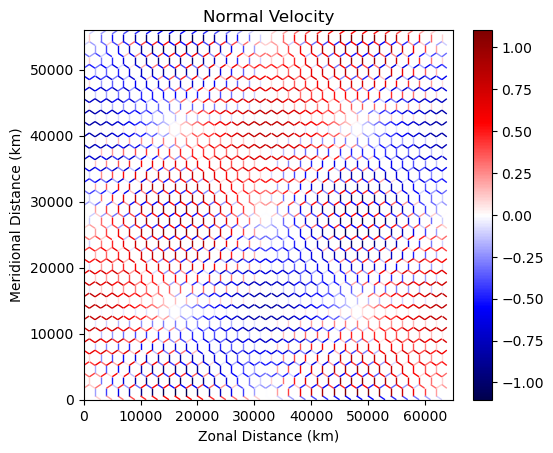

In [41]:
fig, ax, _, _ = edgeHeatMapMesh(myMPAS_O, myAnalyticalVelocityNormalToEdge)
ax.set_title("Normal Velocity")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)

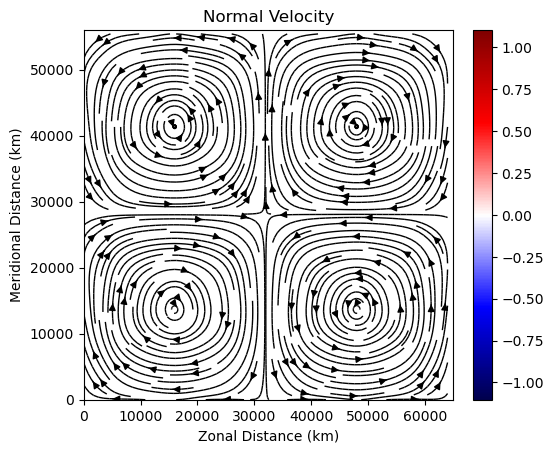

In [44]:
fig, ax, _ = vectorStreamPlotMesh(myMPAS_O, myAnalyticalVelocityNormalToEdge)
ax.set_title("Normal Velocity")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)

In [47]:
myAnalyticalCurlAtVertex = zeros(Float64, myMPAS_O.nVertices)
for iVertex in 1:myMPAS_O.nVertices
    myAnalyticalCurlAtVertex[iVertex] = 
            velocity_curl(myMPAS_O.lX, myMPAS_O.lY, myMPAS_O.xVertex[iVertex], myMPAS_O.yVertex[iVertex])
end

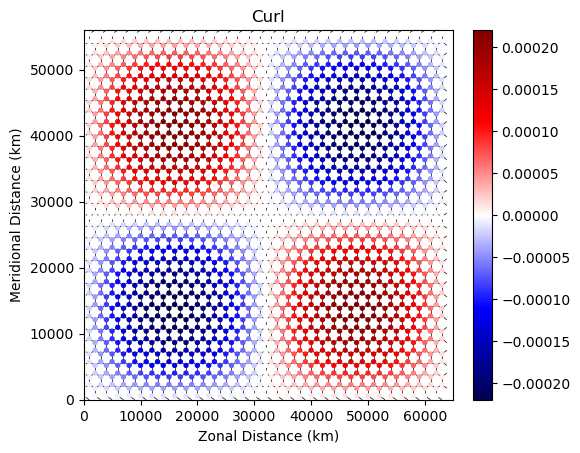

In [51]:
fig, ax, _ = vertexHeatMapMesh(myMPAS_O, myAnalyticalCurlAtVertex, dotsize=8)
ax.set_title("Curl")
ax.set_xlabel("Zonal Distance (km)")
ax.set_ylabel("Meridional Distance (km)")
display(fig)